## random forest classification + bootstrapping
98.1% test accuracy, not rly sure if it's just overfitting... good oob score tho?

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Data

In [68]:
data = pd.read_csv('./data/emotions.csv')

In [70]:
data.shape
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,NEGATIVE


In [71]:
data['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

In [72]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

# Preprocessing

In [62]:
nan_count = np.sum(data.isnull(), axis = 0)
nan_cols = nan_count != 0

print(np.nonzero(nan_cols.to_numpy())) # dataset has no null columns

(array([], dtype=int64),)


In [63]:
#splits the columns with null values into numerical and categorical dfs
col_w_nan = data.columns[nan_count != 0]
num_columns = [col for col in col_w_nan if data[col].dtype == 'int64' or data[col].dtype == 'float64']
num_columns

[]

In [73]:
def preprocess_data(df):
    df = df.copy()

    df['label'] = df['label'].replace(label_mapping)

    y = df['label'].copy()
    X = df.drop('label', axis=1).copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

    return X_train, X_test, y_train, y_test

In [74]:
X_train, X_test, y_train, y_test = preprocess_data(data)

In [75]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1705, 2548)
y_train shape: (1705,)
X_test shape: (427, 2548)
y_test shape: (427,)


# Modeling

In [30]:
rf = RandomForestClassifier(bootstrap=True, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True)

In [34]:
# out-of-bag score
oob_score = rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

y_pred = rf.predict(X_test)

# test accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Out-of-Bag Score: 0.9870967741935484
Accuracy: 0.9812646370023419


Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.97      0.98       125
     NEUTRAL       1.00      0.99      0.99       159
    POSITIVE       0.96      0.99      0.97       143

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427



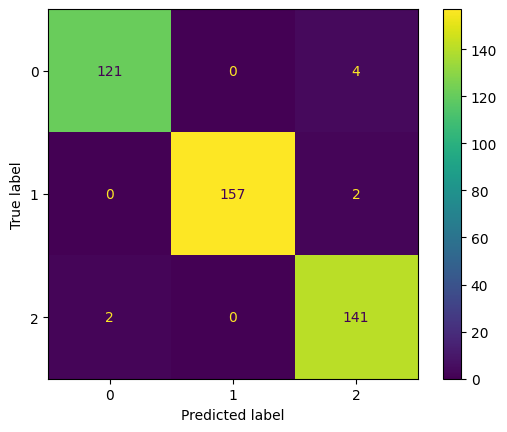

In [38]:
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())
print("Classification Report:\n----------------------\n", clr)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

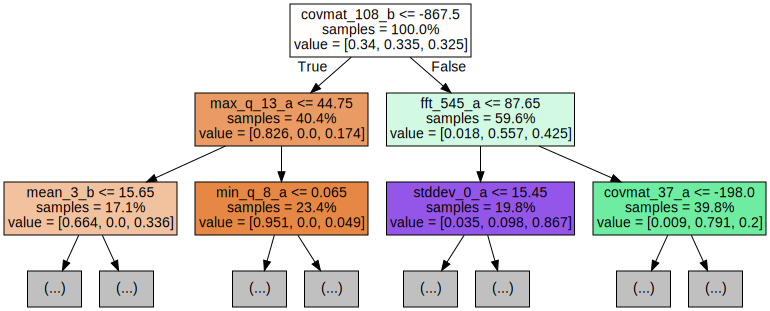

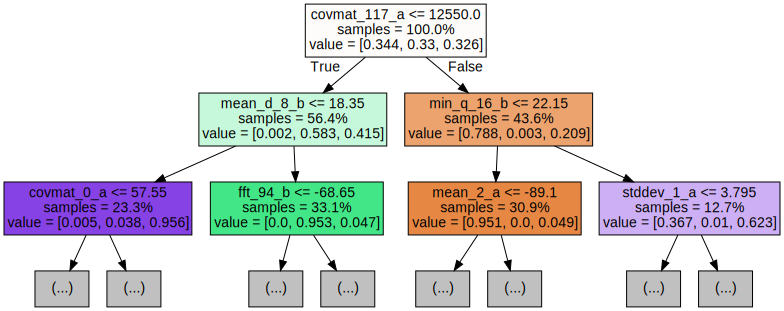

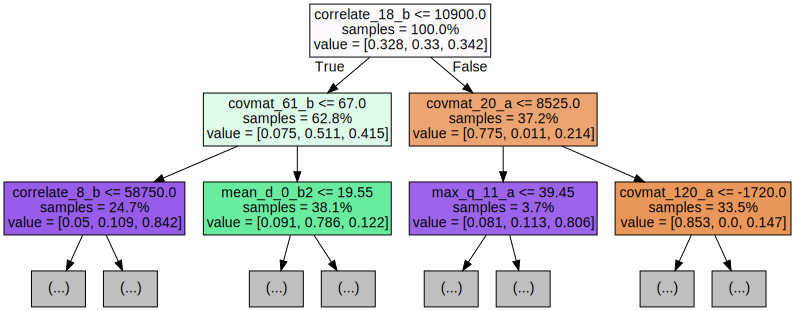

In [28]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

# Hyperparameter search

In [40]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(oob_score=True)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=True),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ab8f8b55510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ab8f8b54910>})

In [41]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 249}


In [42]:
oob_score = best_rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

y_pred = best_rf.predict(X_test)

# test accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Out-of-Bag Score: 0.987683284457478
Accuracy: 0.9836065573770492


Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.98      0.98       125
     NEUTRAL       1.00      0.99      0.99       159
    POSITIVE       0.97      0.99      0.98       143

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427



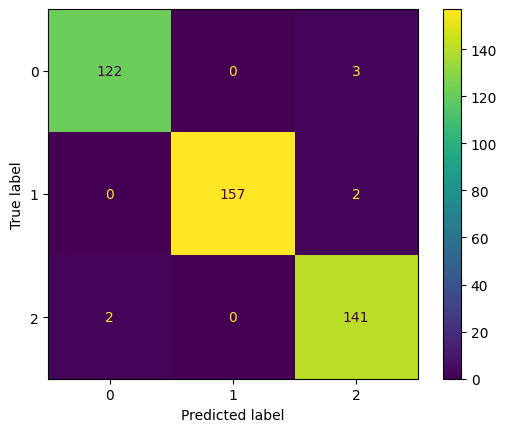

In [43]:
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())
print("Classification Report:\n----------------------\n", clr)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# wowow all that tuning just for 1 less error

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

inputs = data.drop('label', axis=1).copy().to_numpy() # rows are time bins, columns are features
scaled_inputs = std_scaler.fit_transform(inputs)

pca = PCA(n_components=10)
components = pca.fit_transform(scaled_inputs)

In [90]:
print(sum(pca.explained_variance_ratio_))

0.7497457411086159


In [91]:
import numpy as np
nums = np.arange(2, 15)

var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(scaled_inputs)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

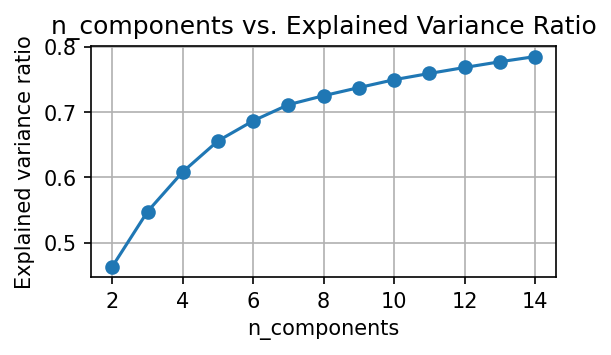

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [ ]:
# 2132 total PCs, 2548 features. not much redundancy i guess.
pca = PCA()
components = pca.fit_transform(scaled_inputs)
print(components.shape)